In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# from tqdm import tqdm_notebook,trange
import numba
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.decomposition import PCA
import math
from matplotlib.patches import Ellipse
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib
from tqdm import trange, notebook
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
notebook.tqdm.pandas()

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
store_path_base = r"/raid6/roozbeh/trip_similarity/"
data_path_base = r"../data/"
morning_df_parquet_name = r"koln_morning_dataframe.parquet"

In [4]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, morning_df_parquet_name))

In [5]:
morningdf_no_nan

time  trip_id             x             y    spd
8484331    21571.0  1401792  22056.400000  17311.490000   0.00
8484575    21571.0   336633  13315.950000  12687.650000   0.00
8484627    21571.0   634311  17555.460000  16582.760000   0.00
8485512    21571.0  1104353  20378.930000  20609.890000   0.00
8485641    21571.0    23620  22693.530000   6839.980000   0.00
...            ...      ...           ...           ...    ...
115788320  36029.0  1159596  20881.964570   8171.417369  22.02
115788351  36029.0   169979  13888.929325  24502.642987   3.65
115788850  36029.0  1208490  15614.362823  12468.408416   4.56
115788966  36029.0  1534301  11829.848768  13325.926609  13.22
115789246  36029.0   235794  13112.235805  15206.884675  13.08

[105204964 rows x 5 columns]

In [6]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [7]:
morning50df = pd.read_parquet(os.path.join(data_path_base,r'morning_trips_df_with_50points.parquet'))

In [8]:
morning50df

point_index     time         x         y    spd
trip_id                                                 
1000007            0  26798.0  0.684278  0.570806   0.00
1000007            1  26804.0  0.685274  0.571578   9.74
1000007            2  26824.0  0.694287  0.576280  11.37
1000007            3  26832.0  0.694457  0.573746  13.45
1000007            4  26841.0  0.690615  0.570789  13.36
...              ...      ...       ...       ...    ...
769414            45  28013.0  0.478249  0.422410   0.00
769414            46  28034.0  0.470983  0.421721  13.19
769414            47  28041.0  0.467166  0.421616  13.08
769414            48  28085.0  0.445628  0.418934   0.53
769414            49  28199.0  0.428012  0.418688  15.73

[8731150 rows x 5 columns]

In [9]:
morning50df.time = (morning50df.time - tmin)/(tmax - tmin)

In [10]:
morning50df

point_index      time         x         y    spd
trip_id                                                  
1000007            0  0.361530  0.684278  0.570806   0.00
1000007            1  0.361945  0.685274  0.571578   9.74
1000007            2  0.363328  0.694287  0.576280  11.37
1000007            3  0.363882  0.694457  0.573746  13.45
1000007            4  0.364504  0.690615  0.570789  13.36
...              ...       ...       ...       ...    ...
769414            45  0.445566  0.478249  0.422410   0.00
769414            46  0.447019  0.470983  0.421721  13.19
769414            47  0.447503  0.467166  0.421616  13.08
769414            48  0.450546  0.445628  0.418934   0.53
769414            49  0.458431  0.428012  0.418688  15.73

[8731150 rows x 5 columns]

## PLOTTING CONFIG

In [171]:
mpl.rc('text', usetex=True)
# matplotlib.use('Agg')
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter',
                                  'DejaVu Sans Mono',
                                  'Bitstream Vera Sans Mono',
                                  'Courier']
sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']
# cyc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# matplotlib.rcParams.update({'font.size': 20,'xtick.labelsize':30,'ytick.labelsize':30})

---------

To use the same sample of trips as clustering with OD (for the sake of compatibility) let's load the same and take its trip_ids

In [12]:
sampleODdf = pd.read_parquet(os.path.join(data_path_base, 'morning_sampleODdf.parquet'))

In [13]:
sampleODdf

orig_time    orig_x    orig_y  orig_spd  dest_time    dest_x  \
trip_id                                                                 
101976    0.916033  0.248212  0.522616       0.0   0.917139  0.252364   
1249482   0.494467  0.678979  0.180198       0.0   0.494743  0.679671   
1064676   0.248651  0.376208  0.414576       0.0   0.249620  0.379531   
1393720   0.305436  0.400191  0.500733       0.0   0.306474  0.392289   
1263272   0.404620  0.345205  0.357355       0.0   0.404897  0.344637   
...            ...       ...       ...       ...        ...       ...   
1067705   0.651542  0.402945  0.404750       0.0   0.651681  0.403204   
258989    0.373911  0.702427  0.388029       0.0   0.374187  0.701619   
1485451   0.632937  0.365770  0.470154       0.0   0.633006  0.365818   
1096458   0.553119  0.467258  0.571665       0.0   0.553811  0.467019   
1281205   0.698160  0.567757  0.428858       0.0   0.698506  0.567243   

           dest_y  dest_spd  
trip_id                      
101976   0.519405      7.77  
1249482  0.179861      7.52  
1064676  0.413418      7.08  
1393720  0.500255     13.36  
1263272  0.357794      8.12  
...           ...       ...  
1067705  0.404770      3.93  
258989   0.388220      8.32  
1485451  0.470127      1.47  
1096458  0.574480     13.31  
1281205  0.428965      5.39  

[3492 rows x 8 columns]

In [14]:
sample50df = morning50df[morning50df.index.isin(sampleODdf.index)]

In [15]:
sample50df

point_index      time         x         y        spd
trip_id                                                      
1000361            0  0.116683  0.496661  0.500492   0.000000
1000361            1  0.116821  0.496818  0.500375   3.450000
1000361            2  0.116890  0.496986  0.500249   5.740000
1000361            3  0.117167  0.498170  0.499347  12.770000
1000361            4  0.117305  0.498946  0.498713  13.860000
...              ...       ...       ...       ...        ...
632179            45  0.547794  0.542064  0.452072  21.440001
632179            46  0.549592  0.564290  0.455904  21.719999
632179            47  0.549869  0.567805  0.456114  21.850000
632179            48  0.550007  0.569551  0.456224  21.730000
632179            49  0.550284  0.573047  0.456445  21.760000

[174600 rows x 5 columns]

In [16]:
174600//50

3492

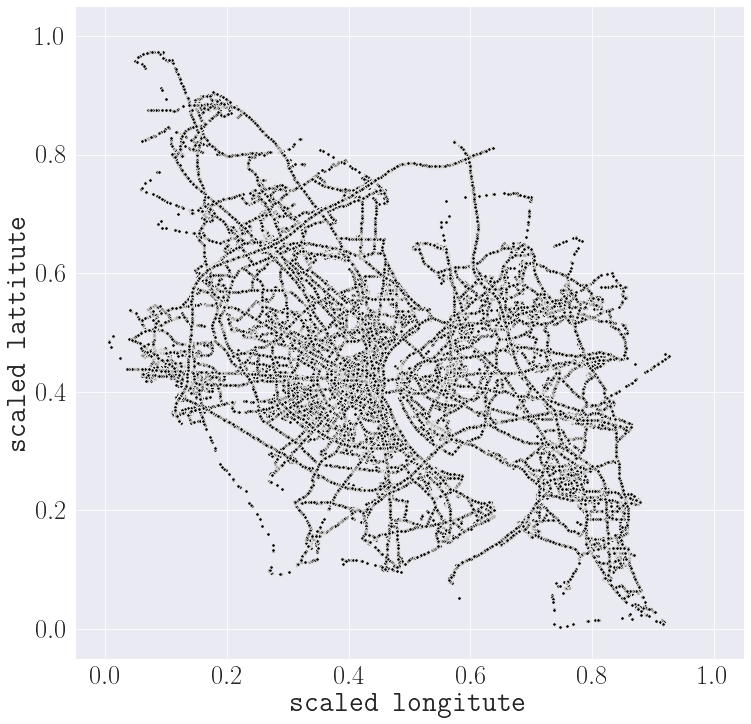

In [17]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = sample50df.x,y=sample50df.y, color='black', alpha=1, s=49, marker='.')
# sns.scatterplot(x = sample50df['orig x'],y=sampleODdf['orig y'], color='black', alpha=1, marker='x', s=30, label='trip origins')
# sns.scatterplot(x = sample50df['dest x'],y=sampleODdf['dest y'], color='red', alpha=0.4, s=12, label='trip destination')
plt.ylim((-0.05,1.05))
plt.xlim((-0.05,1.05))
plt.ylabel('scaled lattitute')
plt.xlabel('scaled longitute');

------

#### Defining distance/similarity

In [18]:
import numba 
from numba import jit

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=True)
def get_wgm_similarity_50pt(arr1, arr2, w_x = 0.5, w_t = 0.5):
    '''
        arr1 and arr2 shape must be (50, 5) as in the DF.values 
    '''
#     if w_x + w_t != 1:
#         raise Exception("sum of w_x and w_t must be 1")
#     if len(df1) != 50 or len(df2) != 50:
#         raise Exception('df1 or df2 has a none 50 length')
        
    pairwise_dists = np.sqrt( np.square(arr1[:,2] - arr2[:,2]) + np.square(arr1[:,3] - arr2[:,3]) )
    pairwise_times = np.absolute(arr1[:,1] - arr2[:,1])
    pairwise_similarities = np.exp(w_x * np.log(1./(1+pairwise_dists)) + w_t * np.log(1./(1+pairwise_times)) )
    
    return np.mean(pairwise_similarities)

##### Let's try getting an affinity matrix

In [19]:
# trip_ids = sample50df.groupby('trip_id').apply(lambda x : 1).index.values

In [20]:
# trip_ids

In [21]:
trip_ids, groups = zip(*list(sample50df.groupby('trip_id')))
trip_id_to_index = {trip_ids[i]:i for i in range(len(trip_ids))}

In [22]:
np.array(trip_ids).shape

(3492,)

In [23]:
groups_values = [group.values for group in groups]

In [24]:
groups_values_array = np.array(groups_values)

In [25]:
groups_values_array.shape

(3492, 50, 5)

In [26]:
for i in range(len(trip_ids)):
    if trip_id_to_index[trip_ids[i]] != i:
        print("holler")

No holler means we can just go by index and place them into the matrix

In [27]:
@numba.jit(nopython=True)
def get_sim_matrix(trip_ids_array, groups_values_array):
    n = len(trip_ids)
    sim_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
    #         idx1 = trip_id_to_index[trip_ids[i]]
    #         idx2 = trip_id_to_index[trip_id2]
            sim_matrix[i,j] = get_wgm_similarity_50pt(groups_values_array[i], groups_values_array[j])
            sim_matrix[j,i] = sim_matrix[i,j] #symmetric
    return sim_matrix

In [28]:
%%time
sim_matrix = get_sim_matrix(np.array(trip_ids), groups_values_array)

Wall time: 32.7 s


In [29]:
sim_matrix

array([[1.        , 0.92880962, 0.84430837, ..., 0.86961918, 0.85239662,
        0.77947504],
       [0.92880962, 1.        , 0.89200555, ..., 0.83147014, 0.80707184,
        0.7936121 ],
       [0.84430837, 0.89200555, 1.        , ..., 0.84427957, 0.75061919,
        0.7236209 ],
       ...,
       [0.86961918, 0.83147014, 0.84427957, ..., 1.        , 0.77431371,
        0.69986718],
       [0.85239662, 0.80707184, 0.75061919, ..., 0.77431371, 1.        ,
        0.75753267],
       [0.77947504, 0.7936121 , 0.7236209 , ..., 0.69986718, 0.75753267,
        1.        ]])

<Figure size 864x720 with 0 Axes>

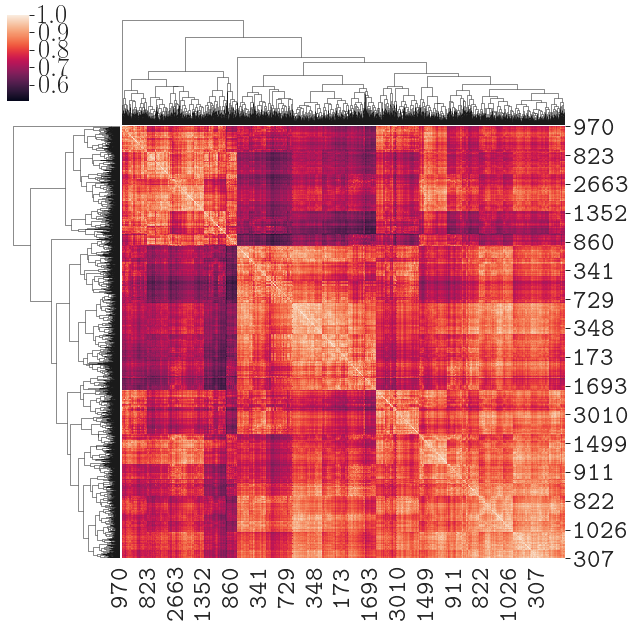

In [30]:
plt.figure(figsize=(12,10))
sns.clustermap(sim_matrix)

In [31]:
sim_matrix.shape

(3492, 3492)

In [32]:
# pairwise_distances([[trip_id] for trip_id in trip_ids], metric = lambda x,y: get_wgm_similarity_50pt())
# sim_matrix = pairwise_distances(sample50df,metric=get_wgm_similarity_50pt,n_jobs=1)
# sim_matrix = pd.read_parquet(os.path.join(data_path_base, 'sim_matrix_scaled_frac0.02.parquet'))

-----

-------

### Attempting clustering

In [33]:
# sim_matrix_lkern = np.exp(-1 * sim_matrix  )

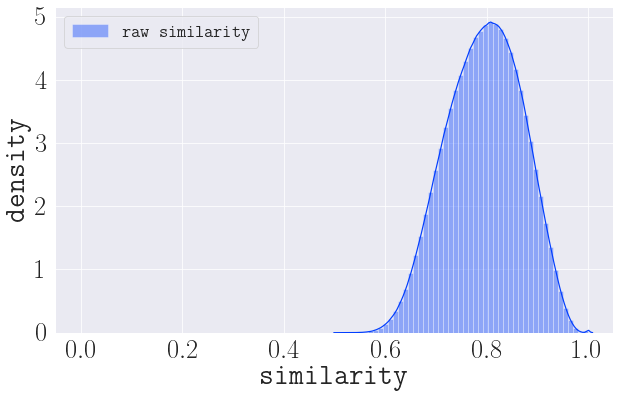

In [34]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(sim_matrix,-1),norm_hist=False,label="raw similarity")
# ax =  sns.distplot(np.reshape(sim_matrix_lkern,-1),norm_hist=True,ax=ax,label="laplacian kernel")
ax.set_xlabel("similarity")
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density")
plt.legend(prop= {"size" : 18})
plt.show()

In [35]:
sampleODdf.columns = ['orig time','orig x','orig y', 'orig spd', 'dest time','dest x','dest y', 'dest spd']

In [36]:
xyt_columns = ['orig time','orig x','orig y','dest time','dest x','dest y']

In [37]:
pca_obj = PCA(n_components=3)

In [38]:
pca_obj.fit(sampleODdf[xyt_columns])

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
np.cumsum(pca_obj.explained_variance_ratio_)

array([0.50141665, 0.8539283 , 0.99988399])

In [40]:
n_clusters = 5

In [41]:
spc_obj = SpectralClustering(n_clusters = n_clusters, affinity='precomputed',n_jobs=-1,assign_labels="discretize",random_state=54321)

In [42]:
spc_obj.fit(sim_matrix)

SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=10, n_jobs=-1, n_neighbors=10, random_state=54321)

In [43]:
Counter(spc_obj.labels_)

Counter({0: 815, 4: 547, 2: 762, 3: 671, 1: 697})

In [44]:
pca_projection = pca_obj.transform(sampleODdf[xyt_columns])

In [45]:
# cmap = plt.cm.get_cmap('jet', 24)

In [46]:
# mpl.colors.to_hex(cmap(5))

In [47]:
# mpl.rcParams['font.family'] = 'sans-serif'

Per below cell, first component is more focused on longitute while the second component is a combination of latitute and time (for both origin and destination points).

In [48]:
pca_obj.components_

array([[ 0.70598704, -0.04055922,  0.01410157,  0.70562792, -0.04047173,
         0.0137723 ],
       [-0.04182329, -0.61474127,  0.34689272, -0.04246323, -0.61526079,
         0.34591973],
       [ 0.00751077,  0.34751905,  0.6181706 ,  0.00794205,  0.34568158,
         0.61439432]])

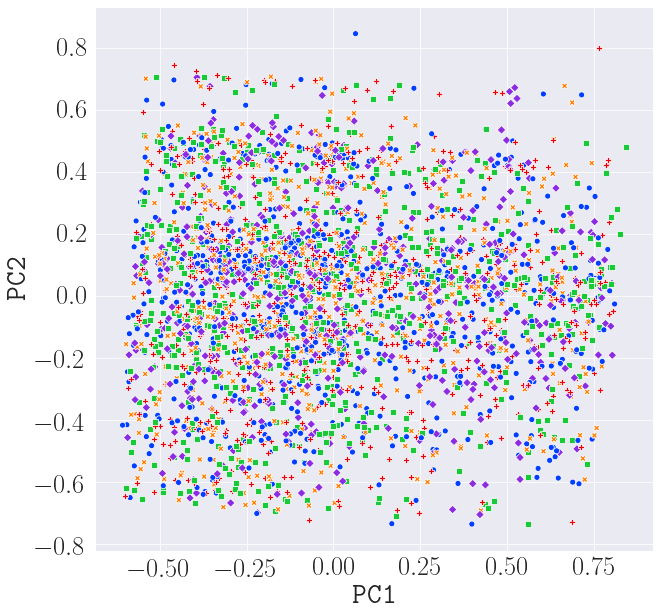

In [49]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj.labels_,
                style=spc_obj.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('bright')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

Way too uninformative. Let's try PCA of the actual 150 dimensional representation.

In [50]:
x50df = sample50df.pivot(index = None,columns = 'point_index', values='x')
x50df.columns = ['x'+str(col) for col in x50df.columns]
y50df = sample50df.pivot(index = None,columns = 'point_index', values='y')
y50df.columns = ['y'+str(col) for col in y50df.columns]
t50df = sample50df.pivot(index = None,columns = 'point_index', values='time')
t50df.columns = ['t'+str(col) for col in t50df.columns]
pivot50df = pd.concat([x50df, y50df, t50df], axis=1)

In [51]:
pivot50df

x0        x1        x2        x3        x4        x5  \
trip_id                                                                         
1000361            0.496661  0.496818  0.496986  0.498170  0.498946  0.499913   
1000460            0.350657  0.355660  0.372793  0.372926  0.373069  0.378611   
100050             0.067888  0.066195  0.064628  0.066717  0.070587  0.079547   
1000559            0.602630  0.602295  0.596184  0.593615  0.584809  0.571992   
1000979            0.559779  0.562830  0.562967  0.562967  0.563195  0.563775   
...                     ...       ...       ...       ...       ...       ...   
59609802_2.028129  0.637750  0.594002  0.580330  0.576289  0.560876  0.557657   
59609802_2.028154  0.637325  0.605033  0.598199  0.596247  0.572437  0.539731   
59609802_2.028243  0.637750  0.591398  0.576548  0.574560  0.542790  0.541909   
600668             0.775085  0.771096  0.768762  0.765259  0.756630  0.754656   
632179             0.677738  0.682893  0.683447  0.687772  0.692081  0.693664   

                         x6        x7        x8        x9  ...       t40  \
trip_id                                                    ...             
1000361            0.499920  0.499920  0.499920  0.499920  ...  0.136464   
1000460            0.383276  0.383644  0.387096  0.387461  ...  0.228247   
100050             0.080103  0.083236  0.087334  0.103164  ...  0.231636   
1000559            0.549367  0.531796  0.531103  0.511785  ...  0.393346   
1000979            0.564120  0.564099  0.563511  0.563190  ...  0.271407   
...                     ...       ...       ...       ...  ...       ...   
59609802_2.028129  0.547864  0.542087  0.511104  0.505664  ...  0.986720   
59609802_2.028154  0.532970  0.524239  0.519978  0.510362  ...  0.806128   
59609802_2.028243  0.535623  0.534575  0.531341  0.517297  ...  0.114400   
600668             0.753136  0.752314  0.752197  0.752197  ...  0.141513   
632179             0.695280  0.696734  0.697240  0.697704  ...  0.545304   

                        t41       t42       t43       t44       t45       t46  \
trip_id                                                                         
1000361            0.137294  0.137571  0.138470  0.140545  0.141583  0.142067   
1000460            0.228317  0.228662  0.228731  0.228801  0.229285  0.229838   
100050             0.232743  0.232951  0.234057  0.235164  0.235302  0.235371   
1000559            0.393969  0.394799  0.395629  0.400263  0.400539  0.401231   
1000979            0.271476  0.271891  0.272098  0.272306  0.272583  0.272721   
...                     ...       ...       ...       ...       ...       ...   
59609802_2.028129  0.987688  0.987758  0.989072  0.989141  0.990040  0.990178   
59609802_2.028154  0.806889  0.807788  0.809102  0.810140  0.810831  0.813114   
59609802_2.028243  0.115299  0.116683  0.116890  0.117651  0.117789  0.118619   
600668             0.141583  0.142136  0.142966  0.143588  0.146078  0.146355   
632179             0.545580  0.546687  0.547171  0.547655  0.547794  0.549592   

                        t47       t48       t49  
trip_id                                          
1000361            0.142205  0.142482  0.143035  
1000460            0.230322  0.230530  0.231498  
100050             0.235856  0.237239  0.237585  
1000559            0.402338  0.403583  0.404966  
1000979            0.272790  0.272998  0.273067  
...                     ...       ...       ...  
59609802_2.028129  0.990939  0.991908  0.994743  
59609802_2.028154  0.813183  0.813667  0.813806  
59609802_2.028243  0.119311  0.120210  0.121732  
600668             0.146562  0.146839  0.147254  
632179             0.549869  0.550007  0.550284  

[3492 rows x 150 columns]

In [52]:
pca_obj.fit(pivot50df)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [53]:
np.cumsum(pca_obj.explained_variance_ratio_)

array([0.56254798, 0.84137614, 0.93526231])

In [54]:
pca_projection = pca_obj.transform(pivot50df)

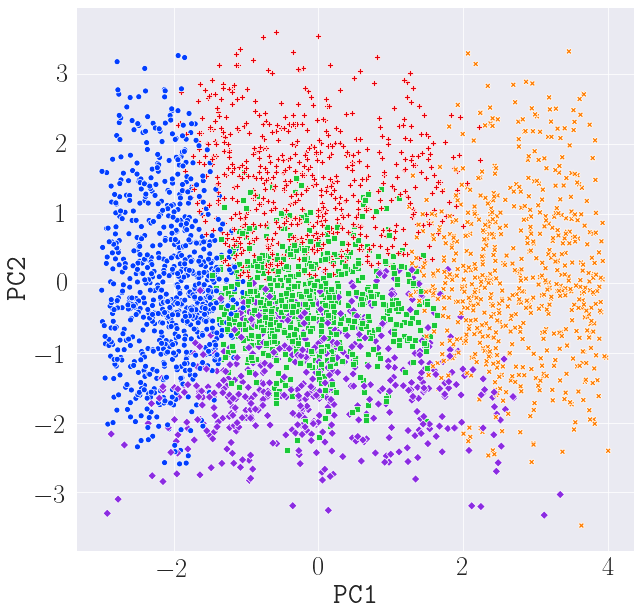

In [55]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj.labels_,
                style=spc_obj.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('bright')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

-----

In [56]:
sum(pca_obj.components_[0][:50]),sum(pca_obj.components_[0][50:100]),sum(pca_obj.components_[0][100:])

(-0.15882052522489645, 0.03384942147569226, 7.069027082799214)

In [57]:
sum(pca_obj.components_[1][:50]),sum(pca_obj.components_[1][50:100]),sum(pca_obj.components_[1][100:])

(6.393541872246353, -2.9063831417578037, 0.1591420036785385)

In [58]:
sum(pca_obj.components_[2][:50]),sum(pca_obj.components_[2][50:100]),sum(pca_obj.components_[2][100:])

(2.924622619608723, 6.391324555029328, 0.03586960090922566)

First component seems to mostly summarize time. Second component seems to focus on X and inversely related to Y to a lesser degree. Third component seems to focus more on Y and then X (less than half).

----

#### Let's try the spectral embedding and see how that looks

In [59]:
from sklearn.manifold import spectral_embedding

In [60]:
spc_embedding = spectral_embedding(sim_matrix,n_components=3)

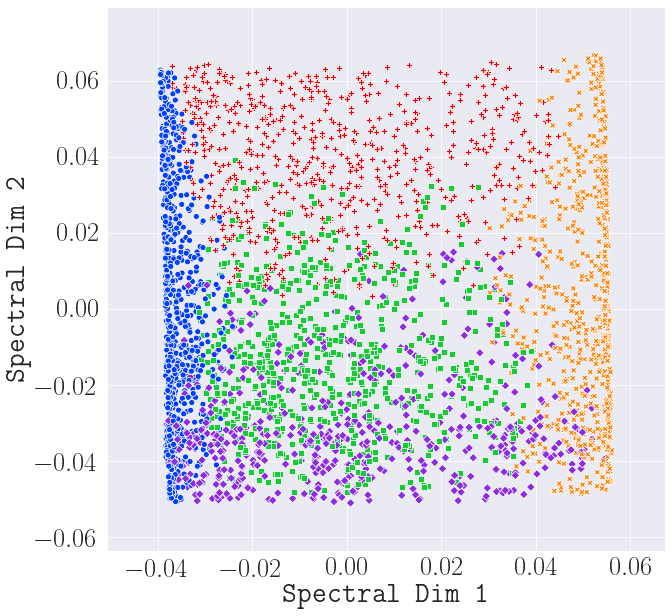

In [61]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_embedding[:,0]*100,spc_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj.labels_,
                     hue_order=range(n_clusters),
                     style=spc_obj.labels_,
                     style_order = range(n_clusters),
                     legend=False,
                     palette=sns.color_palette('bright')[:n_clusters]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

In [ ]:
#For adjusting aesthetics of legend:
# borderpad          the fractional whitespace inside the legend border
# labelspacing       the vertical space between the legend entries
# handlelength       the length of the legend handles
# handletextpad      the pad between the legend handle and text
# borderaxespad      the pad between the axes and legend border
# columnspacing      the spacing between columns

In [62]:
from scipy.sparse import csgraph
from numpy import linalg as LA
L = csgraph.laplacian(sim_matrix, normed=True)
eigenvalues, eigenvectors = LA.eig(L)

Text(0, 0.5, 'Eigenvalues')

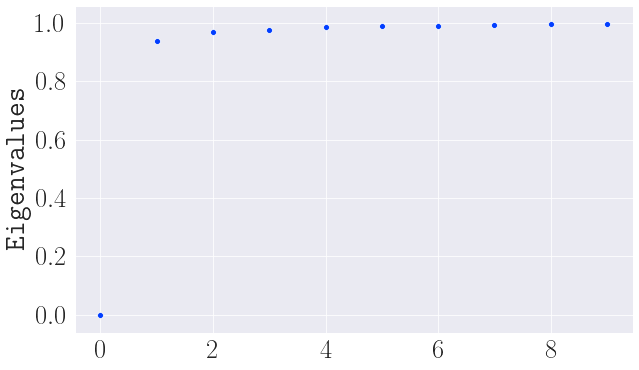

In [63]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=eigenvalues[:10],x=range(10),s=36)
plt.ylabel('Eigenvalues')# of Normalized Laplacian')

In [64]:
eigenvalues

array([9.75804922e-17, 9.40110488e-01, 9.69267161e-01, ...,
       1.00034582e+00, 1.00034586e+00, 1.00034585e+00])

In [65]:
index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:5]

In [66]:
index_largest_gap + 1

array([1, 2, 3, 4, 5], dtype=int64)

<IPython.core.display.Javascript object>


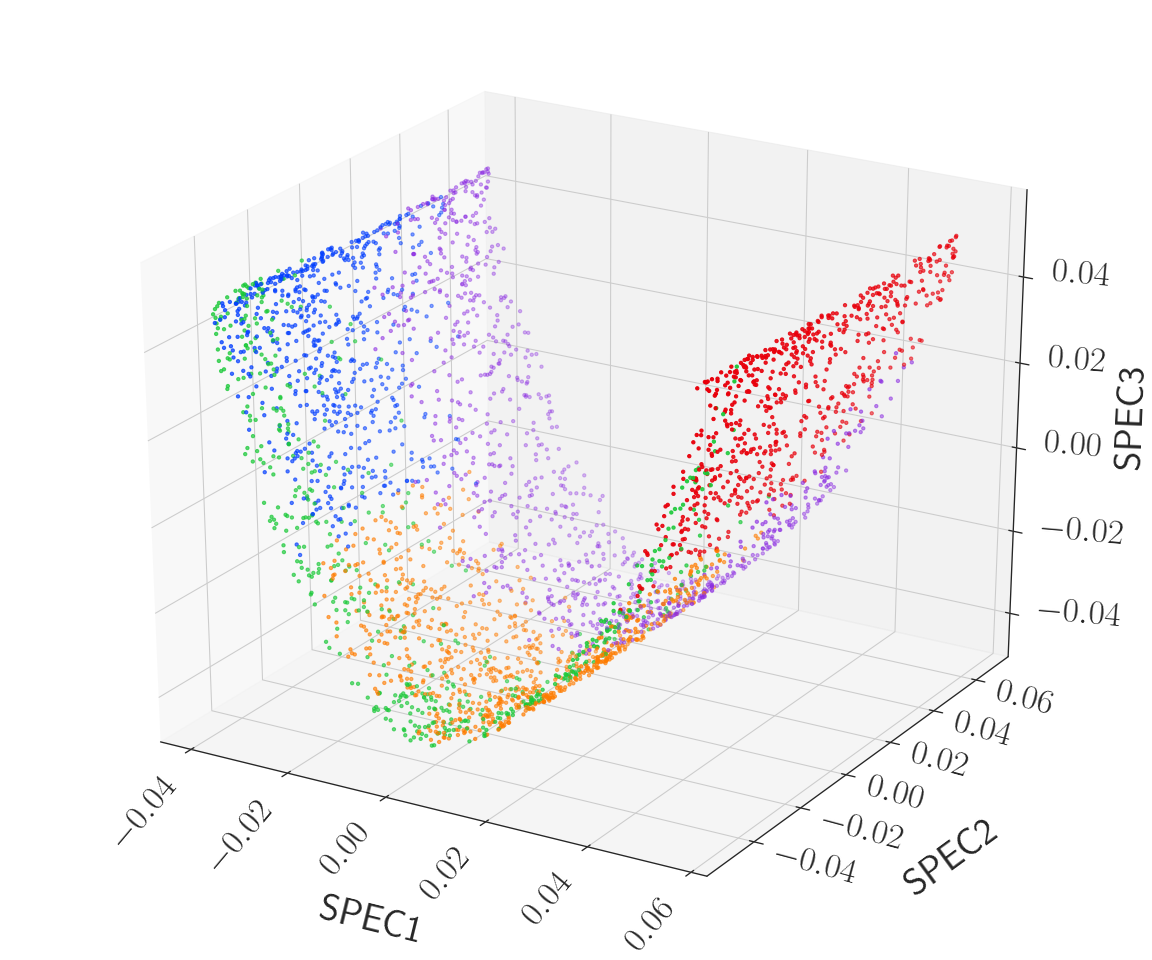

In [146]:
%matplotlib notebook
# sns.set_style('white')
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(spc_embedding[:,0]*100,spc_embedding[:,1]*100,spc_embedding[:,2]*100,
           s=6,
           c=[sns.color_palette('bright')[i] for i in spc_obj_eucl.labels_],)
ax.set_xlabel('SPEC1')
ax.xaxis.labelpad = 45
ax.set_ylabel('SPEC2')
ax.yaxis.labelpad = 45
ax.set_zlabel('SPEC3')
ax.zaxis.labelpad = 35
# ax.tick_params(axis='both', which='major', pad=10)
ax.tick_params(axis='x', which='major', rotation=50)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_horizontalalignment('right')
    tick.label.set_verticalalignment('top')

ax.tick_params(axis='y', which='major', rotation=-15, pad = 5)#, va='baseline',horizontalalignment='left')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_horizontalalignment('left')
    tick.label.set_verticalalignment('center')

ax.tick_params(axis='z', which='major', rotation=-5, pad = 5)#, va='baseline',horizontalalignment='left')
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_horizontalalignment('left')
    tick.label.set_verticalalignment('center')
    
plt.tight_layout()
plt.show()

In [68]:
%matplotlib inline

-----

----

Let's try a simple euclidean distance in R^150 :))

In [69]:
eucl_dist = pairwise_distances(pivot50df,metric='euclidean')

In [70]:
eucl_sim = 1/(1+eucl_dist)

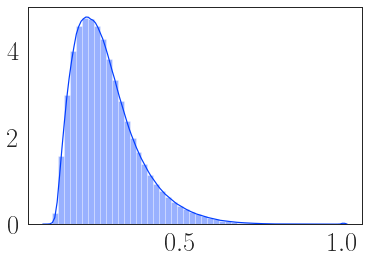

In [71]:
ax =  sns.distplot(np.reshape(eucl_sim,-1),norm_hist=False,label="raw similarity")

In [72]:
spc_obj_eucl = SpectralClustering(n_clusters=n_clusters,affinity='precomputed')

In [73]:
spc_obj_eucl.fit(eucl_sim)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

In [ ]:
Counter(spc_obj_eucl.labels_) # this is when we used rbf and let the spc obj do the job itself.

In [75]:
Counter(spc_obj_eucl.labels_) # this is when we precompute the eucl_sim

Counter({0: 596, 2: 576, 1: 781, 4: 895, 3: 644})

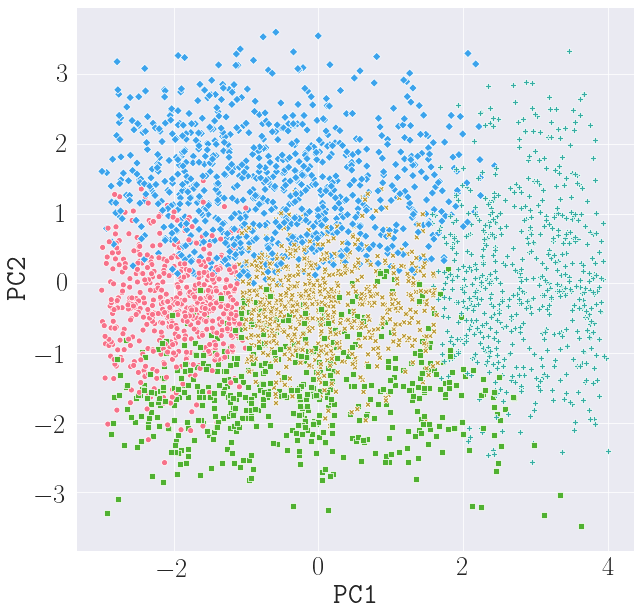

In [78]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj_eucl.labels_,
                style=spc_obj_eucl.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('husl')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [79]:
# spc_eucl_embedding = spectral_embedding(np.exp(-2 * eucl_dist ** 2),n_components=2)
spc_eucl_embedding = spectral_embedding(eucl_sim,n_components=5)

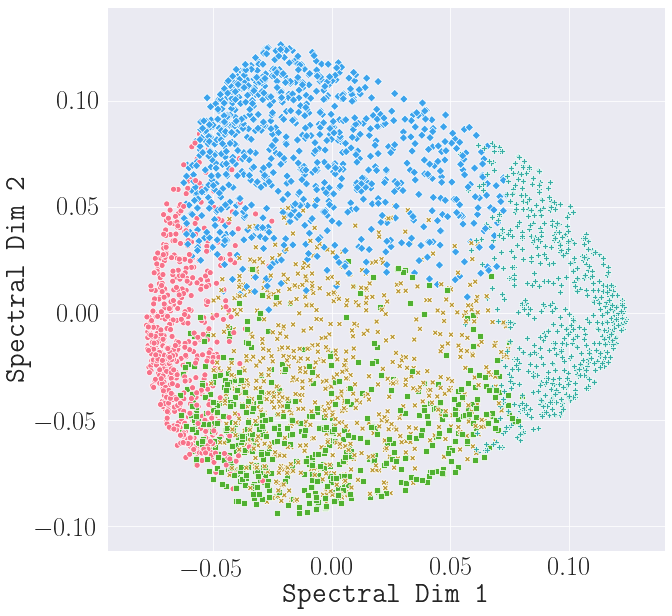

In [80]:
%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_eucl_embedding[:,0]*100,spc_eucl_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj_eucl.labels_,
                     hue_order=range(n_clusters),
                     style=spc_obj_eucl.labels_,
                     style_order = range(n_clusters),
                     legend=False,
                     palette=sns.color_palette('husl')[:n_clusters]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

<IPython.core.display.Javascript object>


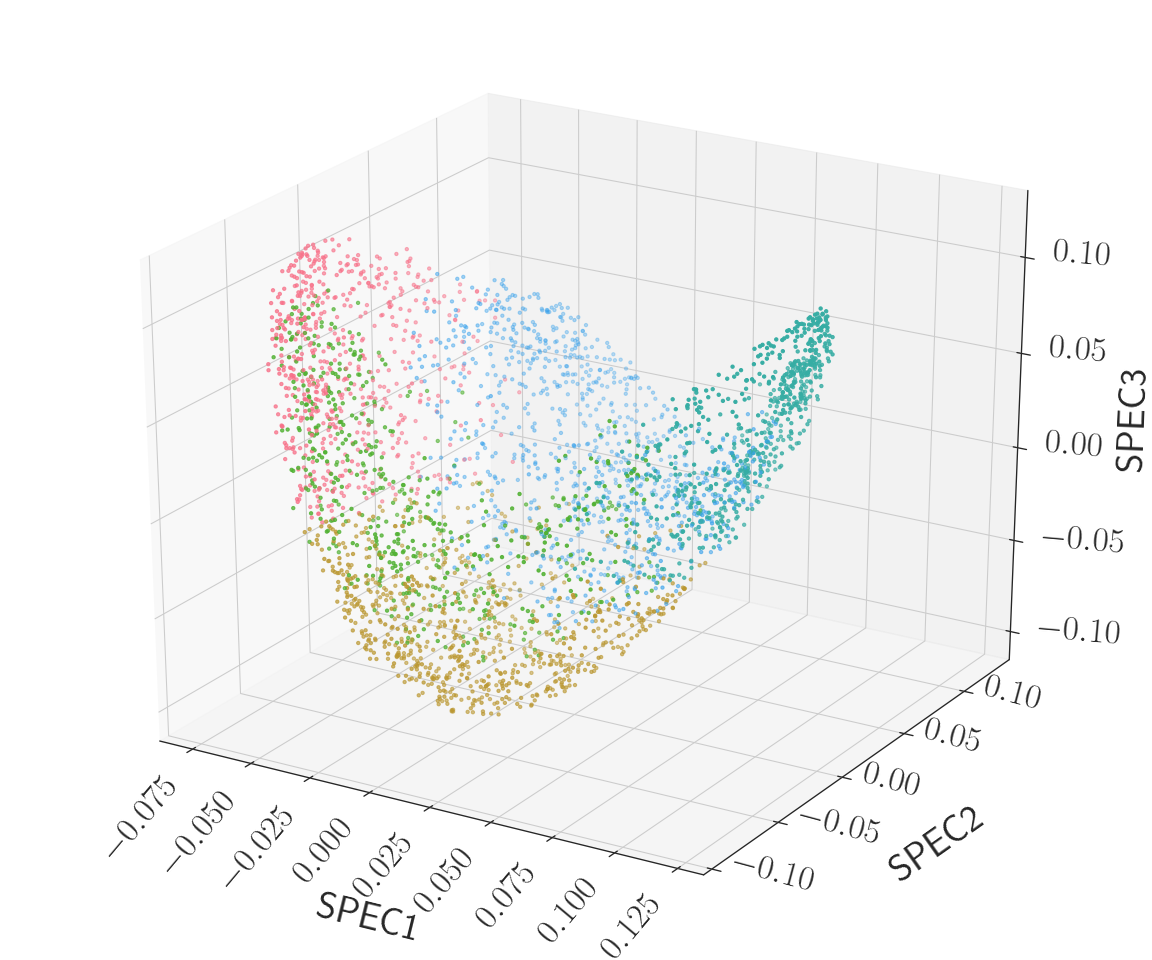

In [141]:
%matplotlib notebook
# sns.set_style('white')
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(spc_eucl_embedding[:,0]*100,spc_eucl_embedding[:,1]*100,spc_eucl_embedding[:,2]*100,
           s=6,
           c=[sns.color_palette('husl')[i] for i in spc_obj_eucl.labels_],)
ax.set_xlabel('SPEC1')
ax.xaxis.labelpad = 45
ax.set_ylabel('SPEC2')
ax.yaxis.labelpad = 35
ax.set_zlabel('SPEC3')
ax.zaxis.labelpad = 35
# ax.tick_params(axis='both', which='major', pad=10)
ax.tick_params(axis='x', which='major', rotation=50)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_horizontalalignment('right')
    tick.label.set_verticalalignment('top')

ax.tick_params(axis='y', which='major', rotation=-15, pad = 5)#, va='baseline',horizontalalignment='left')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_horizontalalignment('left')
    tick.label.set_verticalalignment('baseline')

ax.tick_params(axis='z', which='major', rotation=-5, pad = 5)#, va='baseline',horizontalalignment='left')
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_horizontalalignment('left')
    tick.label.set_verticalalignment('center')
    
plt.tight_layout()
plt.show()

In [147]:
%matplotlib inline

-----

In [166]:
tempdf = sample50df.copy()

In [167]:
tripid_wgm_cluster_df = pd.DataFrame(list(zip( pivot50df.index,spc_obj.labels_)), columns=['trip_id','cluster'])
tripid_eucl_cluster_df = pd.DataFrame(list(zip( pivot50df.index,spc_obj_eucl.labels_)), columns=['trip_id','cluster'])
tripid_wgm_cluster_df.set_index('trip_id', inplace=True)
tripid_eucl_cluster_df.set_index('trip_id', inplace=True)
tempdf = tempdf.merge(tripid_wgm_cluster_df, left_index = True, right_index=True)
tempdf = tempdf.merge(tripid_eucl_cluster_df, left_index = True, right_index=True, suffixes = ['_wgm', '_eucl'])

In [168]:
tempdf

point_index      time         x         y        spd  cluster_wgm  \
trip_id                                                                      
1000361            0  0.116683  0.496661  0.500492   0.000000            0   
1000361            1  0.116821  0.496818  0.500375   3.450000            0   
1000361            2  0.116890  0.496986  0.500249   5.740000            0   
1000361            3  0.117167  0.498170  0.499347  12.770000            0   
1000361            4  0.117305  0.498946  0.498713  13.860000            0   
...              ...       ...       ...       ...        ...          ...   
632179            45  0.547794  0.542064  0.452072  21.440001            3   
632179            46  0.549592  0.564290  0.455904  21.719999            3   
632179            47  0.549869  0.567805  0.456114  21.850000            3   
632179            48  0.550007  0.569551  0.456224  21.730000            3   
632179            49  0.550284  0.573047  0.456445  21.760000            3   

         cluster_eucl  
trip_id                
1000361             0  
1000361             0  
1000361             0  
1000361             0  
1000361             0  
...               ...  
632179              4  
632179              4  
632179              4  
632179              4  
632179              4  

[174600 rows x 7 columns]

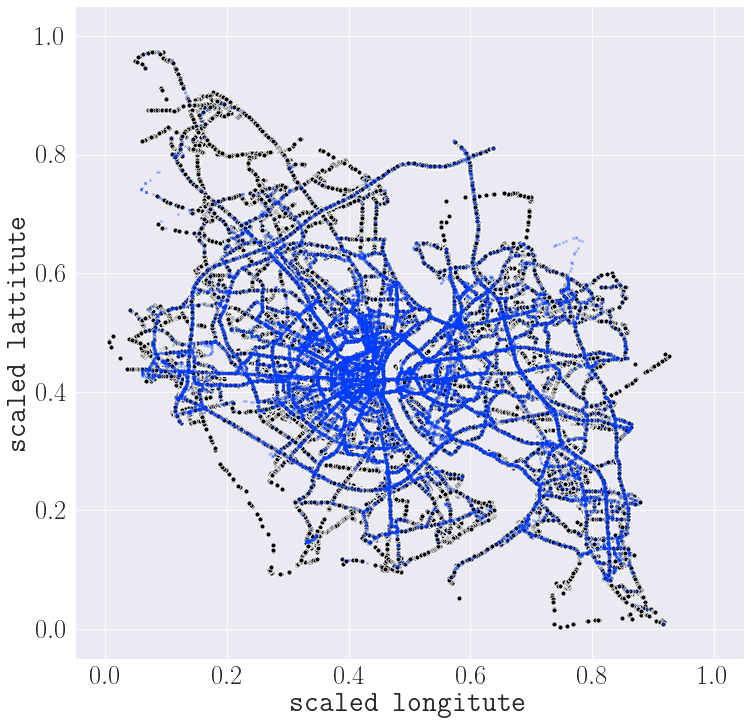

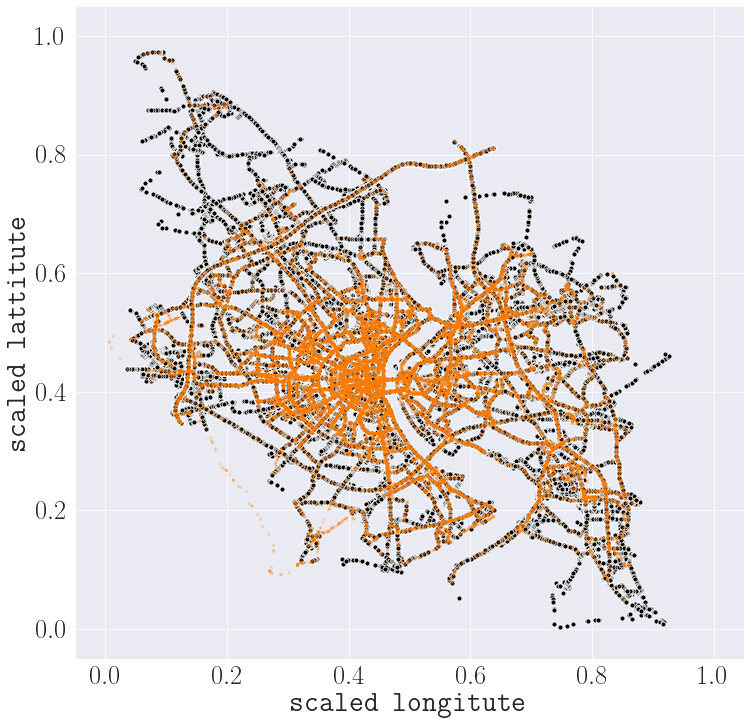

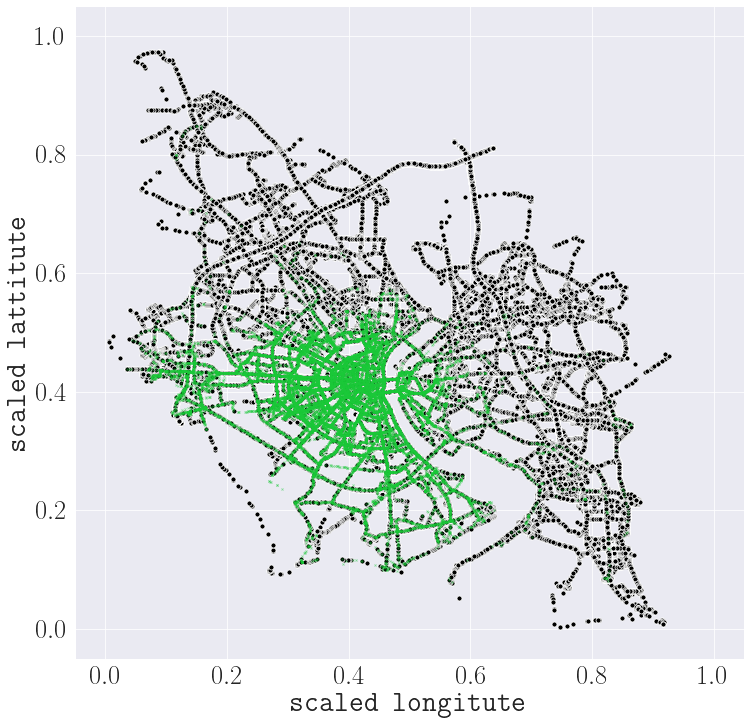

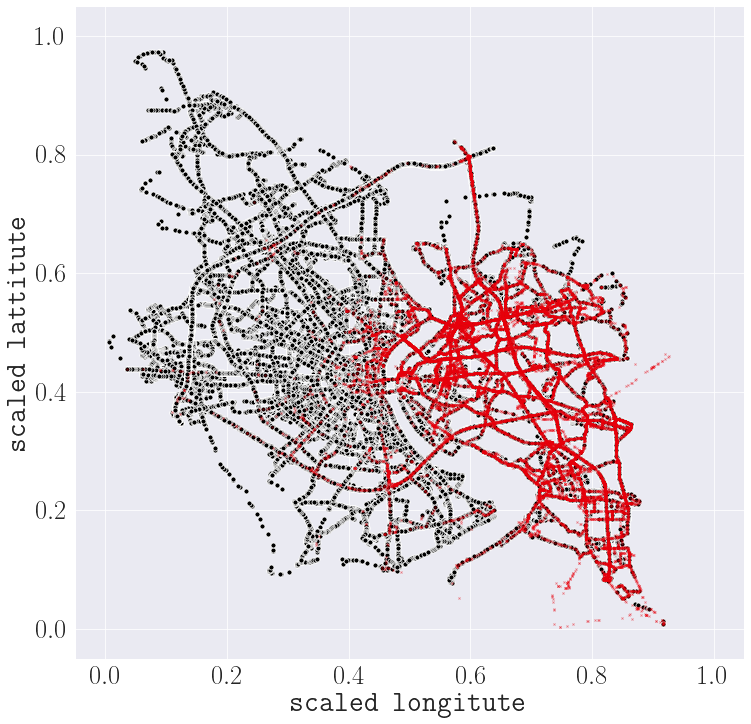

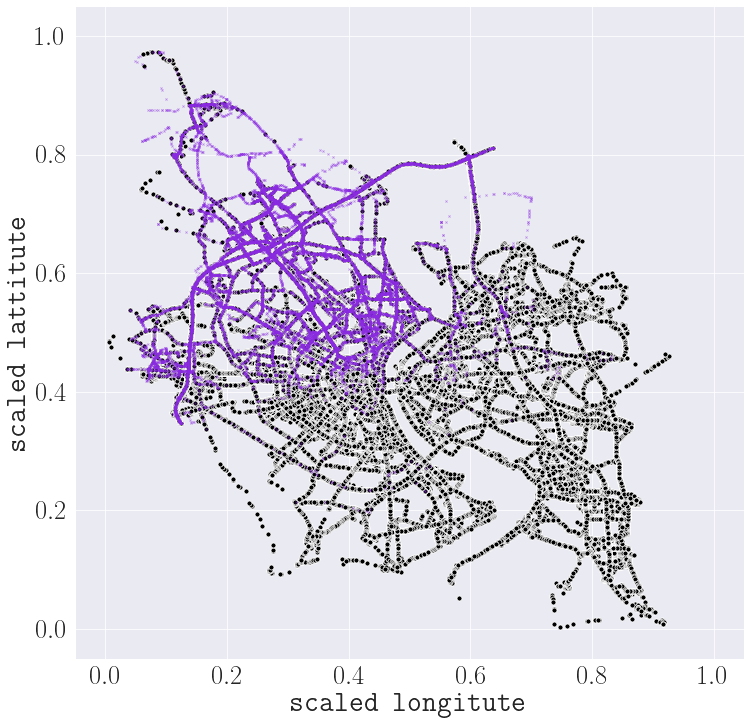

In [172]:
for i in range(5):
    plt.figure(figsize=(12,12))
    sns.scatterplot(x = tempdf[tempdf.cluster_wgm != i].x,y=tempdf[tempdf.cluster_wgm != i].y, color='black', alpha=1, s=100, marker='.')
    sns.scatterplot(x = tempdf[tempdf.cluster_wgm == i].x,y=tempdf[tempdf.cluster_wgm == i].y, color=sns.color_palette('bright')[i], alpha=0.5, s=4, marker='x')
    # sns.scatterplot(x = sample50df['orig x'],y=sampleODdf['orig y'], color='black', alpha=1, marker='x', s=30, label='trip origins')
    # sns.scatterplot(x = sample50df['dest x'],y=sampleODdf['dest y'], color='red', alpha=0.4, s=12, label='trip destination')
    plt.ylim((-0.05,1.05))
    plt.xlim((-0.05,1.05))
    plt.ylabel('scaled lattitute')
    plt.xlabel('scaled longitute');
    plt.show()

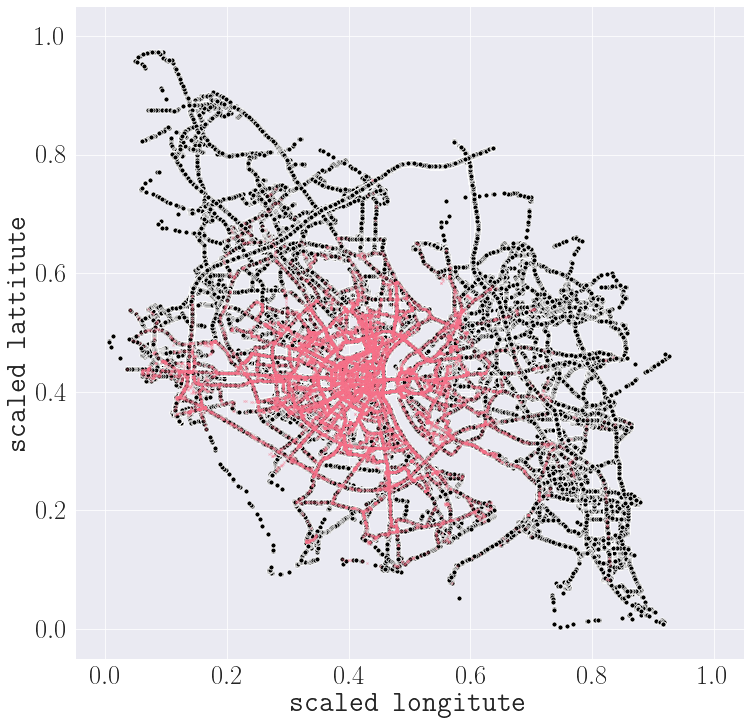

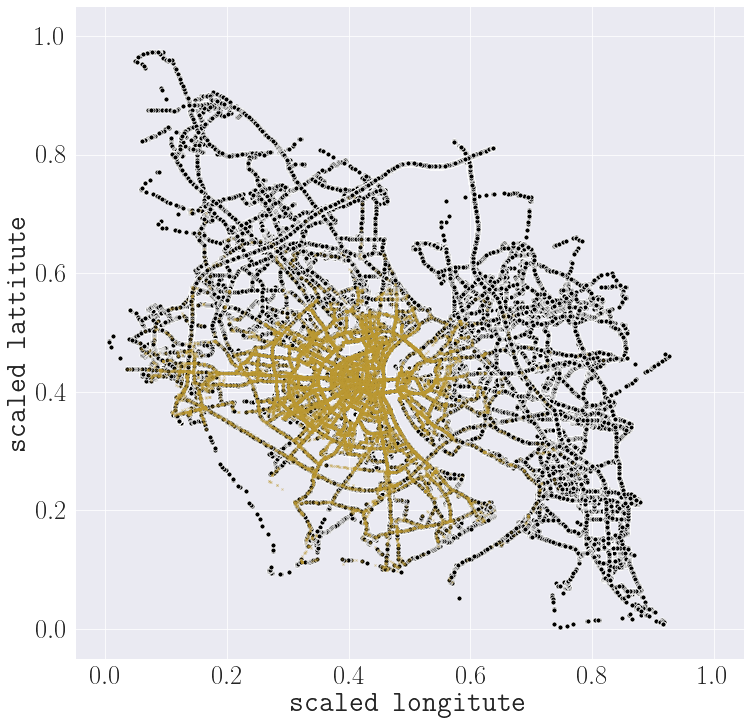

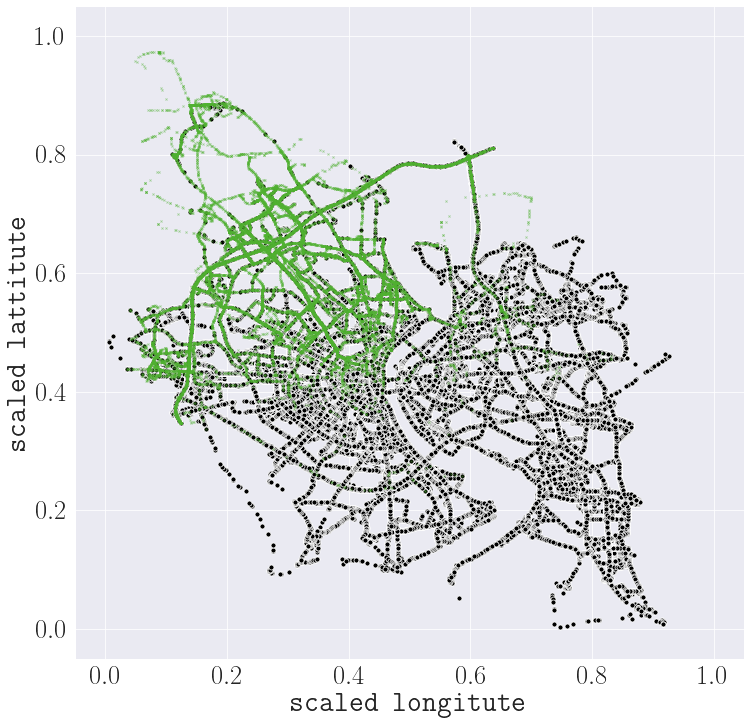

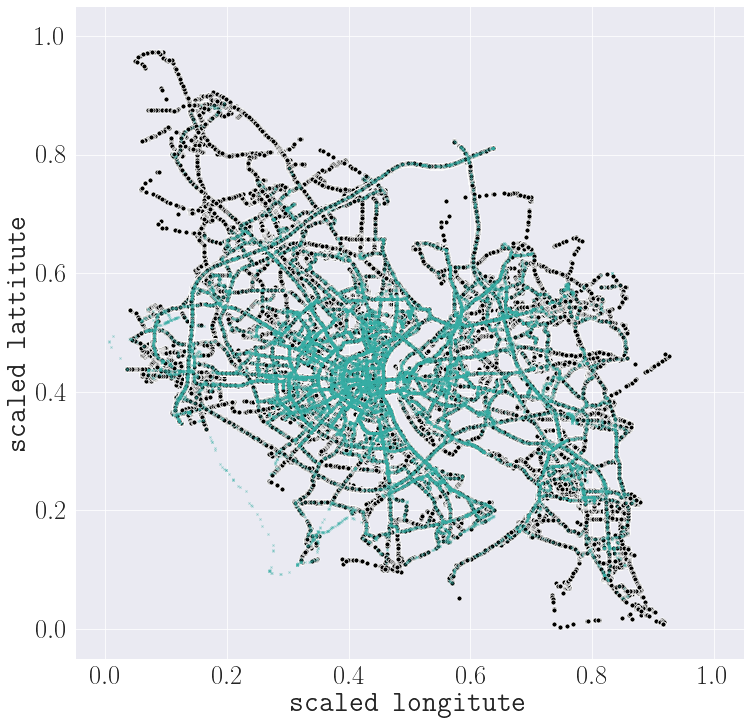

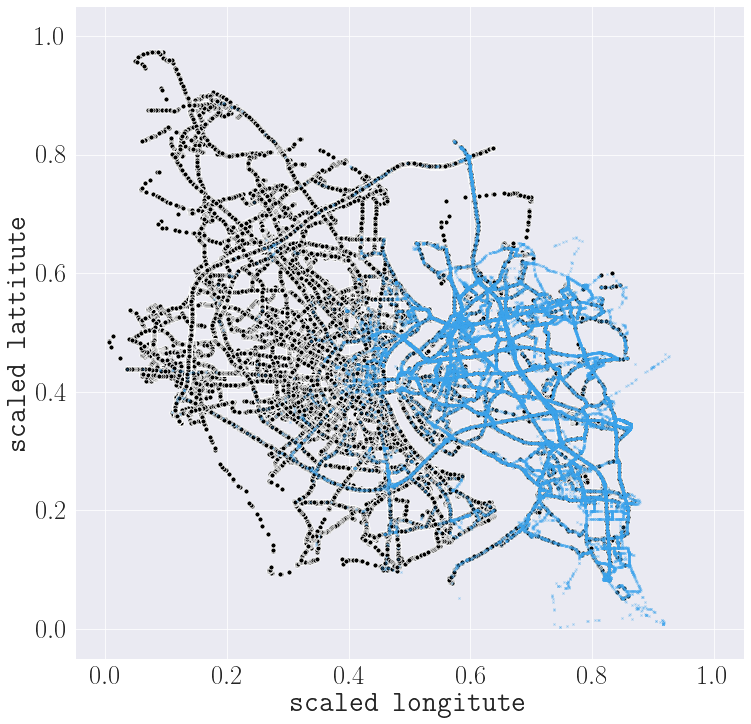

In [173]:
%matplotlib inline
for i in range(5):
    plt.figure(figsize=(12,12))
    sns.scatterplot(x = tempdf[tempdf.cluster_eucl != i].x,y=tempdf[tempdf.cluster_eucl != i].y, color='black', alpha=1, s=100, marker='.')
    sns.scatterplot(x = tempdf[tempdf.cluster_eucl == i].x,y=tempdf[tempdf.cluster_eucl == i].y, color=sns.color_palette('husl')[i], alpha=0.5, s=4, marker='x')
    # sns.scatterplot(x = sample50df['orig x'],y=sampleODdf['orig y'], color='black', alpha=1, marker='x', s=30, label='trip origins')
    # sns.scatterplot(x = sample50df['dest x'],y=sampleODdf['dest y'], color='red', alpha=0.4, s=12, label='trip destination')
    plt.ylim((-0.05,1.05))
    plt.xlim((-0.05,1.05))
    plt.ylabel('scaled lattitute')
    plt.xlabel('scaled longitute');
    plt.show()

In [174]:
tempdf

point_index      time         x         y        spd  cluster_wgm  \
trip_id                                                                      
1000361            0  0.116683  0.496661  0.500492   0.000000            0   
1000361            1  0.116821  0.496818  0.500375   3.450000            0   
1000361            2  0.116890  0.496986  0.500249   5.740000            0   
1000361            3  0.117167  0.498170  0.499347  12.770000            0   
1000361            4  0.117305  0.498946  0.498713  13.860000            0   
...              ...       ...       ...       ...        ...          ...   
632179            45  0.547794  0.542064  0.452072  21.440001            3   
632179            46  0.549592  0.564290  0.455904  21.719999            3   
632179            47  0.549869  0.567805  0.456114  21.850000            3   
632179            48  0.550007  0.569551  0.456224  21.730000            3   
632179            49  0.550284  0.573047  0.456445  21.760000            3   

         cluster_eucl  
trip_id                
1000361             0  
1000361             0  
1000361             0  
1000361             0  
1000361             0  
...               ...  
632179              4  
632179              4  
632179              4  
632179              4  
632179              4  

[174600 rows x 7 columns]

In [ ]:
# sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
# sns.set_palette("bright")
# mpl.rcParams['font.family'] = ['monospace']

In [ ]:
# ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']
# sampleODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [175]:
del ax

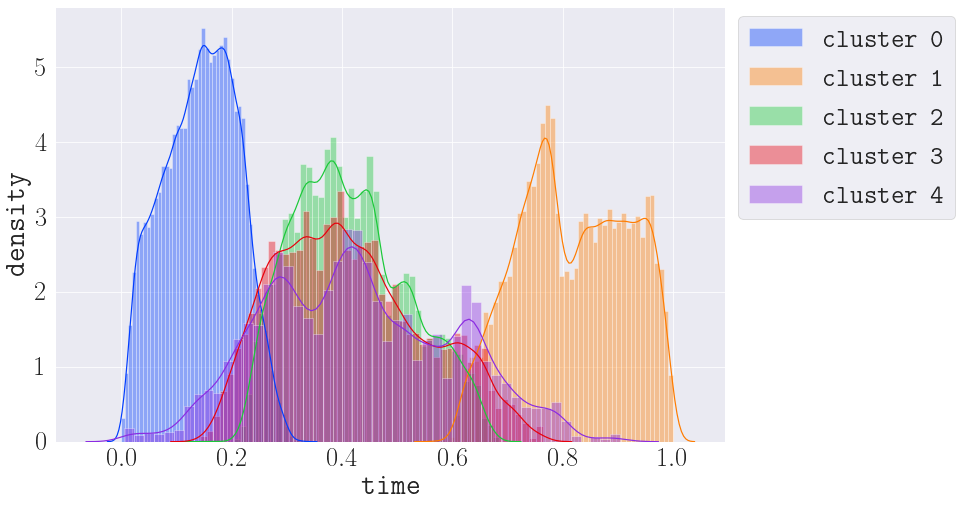

In [205]:
ax = None
colors = sns.color_palette("bright", 5)
plt.figure(figsize=(12,8))
labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
for i in range(5):
    cluster = tempdf[tempdf.cluster_wgm == i]
    if ax: ax = sns.distplot(cluster['time'], ax = ax, color = colors[i], kde=True, label = labels[i], bins=50)
    else:  ax = sns.distplot(cluster['time'], color = colors[i], kde=True, label = labels[i], bins=50)
plt.legend(bbox_to_anchor=(1., 1.01))
plt.ylabel('density')
plt.show()

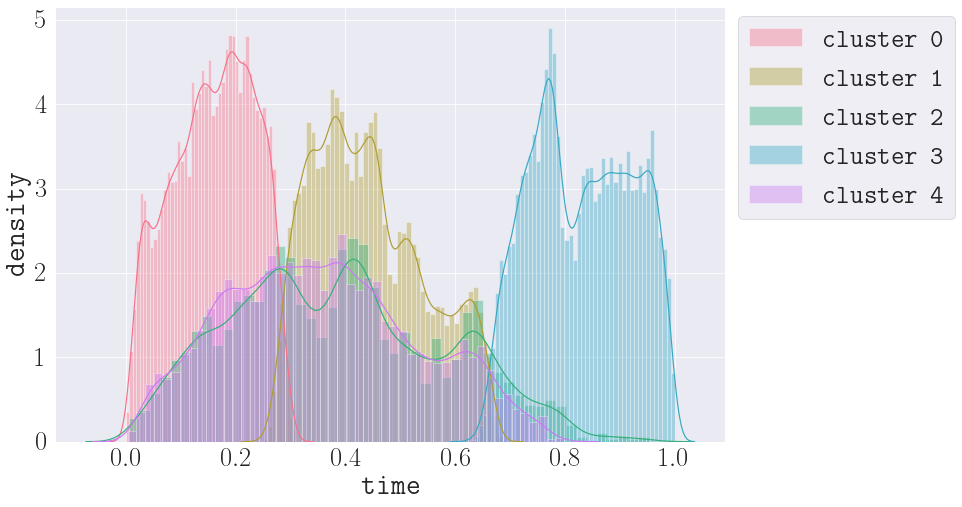

In [206]:
ax = None
colors = sns.color_palette("husl", 5)
plt.figure(figsize=(12,8))
labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
for i in range(5):
    cluster = tempdf[tempdf.cluster_eucl == i]
    if ax: ax = sns.distplot(cluster['time'], ax = ax, color = colors[i], kde=True, label = labels[i], bins=50)
    else:  ax = sns.distplot(cluster['time'], color = colors[i], kde=True, label = labels[i], bins=50)
plt.legend(bbox_to_anchor=(1., 1.01))
plt.ylabel('density')
plt.show()

Let's define some sort of label for trips so that we can measure against!

In [199]:
tempdf['xgrid'] = (tempdf['x'] * 10).astype(np.int)
tempdf['ygrid'] = (tempdf['y'] * 10).astype(np.int)
tempdf['tgrid'] = (tempdf['time'] * 10).astype(np.int)

In [200]:
tempdf

point_index      time         x         y        spd  cluster_wgm  \
trip_id                                                                      
1000361            0  0.116683  0.496661  0.500492   0.000000            0   
1000361            1  0.116821  0.496818  0.500375   3.450000            0   
1000361            2  0.116890  0.496986  0.500249   5.740000            0   
1000361            3  0.117167  0.498170  0.499347  12.770000            0   
1000361            4  0.117305  0.498946  0.498713  13.860000            0   
...              ...       ...       ...       ...        ...          ...   
632179            45  0.547794  0.542064  0.452072  21.440001            3   
632179            46  0.549592  0.564290  0.455904  21.719999            3   
632179            47  0.549869  0.567805  0.456114  21.850000            3   
632179            48  0.550007  0.569551  0.456224  21.730000            3   
632179            49  0.550284  0.573047  0.456445  21.760000            3   

         cluster_eucl  xgrid  ygrid  tgrid  
trip_id                                     
1000361             0      4      5      1  
1000361             0      4      5      1  
1000361             0      4      5      1  
1000361             0      4      4      1  
1000361             0      4      4      1  
...               ...    ...    ...    ...  
632179              4      5      4      5  
632179              4      5      4      5  
632179              4      5      4      5  
632179              4      5      4      5  
632179              4      5      4      5  

[174600 rows x 10 columns]

In [237]:
def label_coverage(grid, label='cluster_wgm'):
    most_common_cluster, count = Counter(grid[label]).most_common(1)[0]
    return most_common_cluster, count/len(grid)

In [244]:
xygrid_coverage = tempdf.groupby(['xgrid','ygrid']).apply(label_coverage, 'cluster_wgm')

In [245]:
tgrid_coverage = tempdf.groupby('tgrid').apply(label_coverage, 'cluster_wgm')

In [246]:
xygrid_coverage_eucl = tempdf.groupby(['xgrid','ygrid']).apply(label_coverage, 'cluster_eucl')

In [247]:
tgrid_coverage_eucl = tempdf.groupby('tgrid').apply(label_coverage, 'cluster_eucl')

In [256]:
np.mean(list(zip(*xygrid_coverage))[1]), np.std(list(zip(*xygrid_coverage))[1])

(0.6242010794802352, 0.20711812646934913)

In [260]:
np.mean(list(zip(*xygrid_coverage_eucl))[1]), np.std(list(zip(*xygrid_coverage_eucl))[1])

(0.7256768151632708, 0.2311793011004118)

In [261]:
np.mean(list(zip(*tgrid_coverage))[1]), np.std(list(zip(*tgrid_coverage))[1])

(0.6716536127593353, 0.273409903402359)

In [262]:
np.mean(list(zip(*tgrid_coverage_eucl))[1]), np.std(list(zip(*tgrid_coverage_eucl))[1])

(0.6112937901703135, 0.2293044582459455)

In [265]:
nclustdf

point_index      time         x         y        spd  cluster_wgm  \
trip_id                                                                      
1000361            0  0.116683  0.496661  0.500492   0.000000            0   
1000361            1  0.116821  0.496818  0.500375   3.450000            0   
1000361            2  0.116890  0.496986  0.500249   5.740000            0   
1000361            3  0.117167  0.498170  0.499347  12.770000            0   
1000361            4  0.117305  0.498946  0.498713  13.860000            0   
...              ...       ...       ...       ...        ...          ...   
632179            45  0.547794  0.542064  0.452072  21.440001            3   
632179            46  0.549592  0.564290  0.455904  21.719999            3   
632179            47  0.549869  0.567805  0.456114  21.850000            3   
632179            48  0.550007  0.569551  0.456224  21.730000            3   
632179            49  0.550284  0.573047  0.456445  21.760000            3   

         cluster_eucl  xgrid  ygrid  tgrid  
trip_id                                     
1000361             0      4      5      1  
1000361             0      4      5      1  
1000361             0      4      5      1  
1000361             0      4      4      1  
1000361             0      4      4      1  
...               ...    ...    ...    ...  
632179              4      5      4      5  
632179              4      5      4      5  
632179              4      5      4      5  
632179              4      5      4      5  
632179              4      5      4      5  

[174600 rows x 10 columns]

In [278]:
labels

trip_id
1000361              0
1000460              0
100050               0
1000559              0
1000979              0
                    ..
59609802_2.028129    1
59609802_2.028154    1
59609802_2.028243    0
600668               0
632179               1
Name: cluster_wgm, Length: 3492, dtype: int32

trip_id
1000361    0
1000361    0
1000361    0
1000361    0
1000361    0
          ..
632179     1
632179     1
632179     1
632179     1
632179     1
Length: 174600, dtype: int64

In [ ]:
nclustdf = sample50df.copy()

In [286]:
nclustdf.merge(labels, left_index=True, right_index=True)

point_index      time         x         y        spd  cluster_wgm
trip_id                                                                   
1000361            0  0.116683  0.496661  0.500492   0.000000            0
1000361            1  0.116821  0.496818  0.500375   3.450000            0
1000361            2  0.116890  0.496986  0.500249   5.740000            0
1000361            3  0.117167  0.498170  0.499347  12.770000            0
1000361            4  0.117305  0.498946  0.498713  13.860000            0
...              ...       ...       ...       ...        ...          ...
632179            45  0.547794  0.542064  0.452072  21.440001            1
632179            46  0.549592  0.564290  0.455904  21.719999            1
632179            47  0.549869  0.567805  0.456114  21.850000            1
632179            48  0.550007  0.569551  0.456224  21.730000            1
632179            49  0.550284  0.573047  0.456445  21.760000            1

[174600 rows x 6 columns]

In [299]:
np.random.seed(54321)
confusion_per_n_cluster = []
nclustdf = tempdf.copy()
for n_clusters in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    confusion_per_repeat = []
    for repeat in range(3):
        spc_obj = SpectralClustering(n_clusters = n_clusters, affinity='precomputed',n_jobs=1,assign_labels="kmeans")
        spc_obj.fit(sim_matrix)
        
        eucl_dist = pairwise_distances(pivot50df,metric='euclidean')
        eucl_sim = 1 / (1 + eucl_dist)
        spc_obj_eucl = SpectralClustering(n_clusters=n_clusters,affinity='precomputed')
        spc_obj_eucl.fit(eucl_sim)
        
        wgm_labels = pd.Series(data=spc_obj.labels_, index=pivot50df.index, name='cluster_wgm')
        eucl_labels = pd.Series(data=spc_obj_eucl.labels_, index=pivot50df.index, name='cluster_eucl')
        
        nclustdf['cluster_wgm'] = nclustdf.apply(lambda row: wgm_labels[row.name],axis=1)
        nclustdf['cluster_eucl'] = nclustdf.apply(lambda row: eucl_labels[row.name],axis=1)
        
        wgm_most_common_ratios_per_grid = nclustdf.groupby(['xgrid','ygrid']).apply(label_coverage, 'cluster_wgm')
        _, wgm_most_common_ratios_per_grid = list(zip(*wgm_most_common_ratios_per_grid))
                                          
        eucl_most_common_ratios_per_grid = nclustdf.groupby(['xgrid','ygrid']).apply(label_coverage, 'cluster_eucl')
        _, eucl_most_common_ratios_per_grid = list(zip(*eucl_most_common_ratios_per_grid))
        
        wgm_most_common_ratios_per_time = nclustdf.groupby('tgrid').apply(label_coverage, 'cluster_wgm')
        _, wgm_most_common_ratios_per_time = list(zip(*wgm_most_common_ratios_per_time))
        
        eucl_most_common_ratios_per_time = nclustdf.groupby('tgrid').apply(label_coverage, 'cluster_eucl')
        _, eucl_most_common_ratios_per_time = list(zip(*eucl_most_common_ratios_per_time))
        
        confusion_per_repeat.append([np.mean(wgm_most_common_ratios_per_grid),np.mean(eucl_most_common_ratios_per_grid),
                                     np.mean(wgm_most_common_ratios_per_time),np.mean(eucl_most_common_ratios_per_time),
                                     np.std(wgm_most_common_ratios_per_grid),np.std(eucl_most_common_ratios_per_grid),
                                     np.std(wgm_most_common_ratios_per_time),np.std(eucl_most_common_ratios_per_time)])
    confusion_per_n_cluster.append(np.mean(confusion_per_repeat,axis=0))
    print('n_cluster {} done'.format(n_clusters))

n_cluster 2 done
n_cluster 3 done
n_cluster 4 done
n_cluster 5 done
n_cluster 6 done
n_cluster 7 done
n_cluster 8 done
n_cluster 9 done
n_cluster 10 done
n_cluster 11 done
n_cluster 12 done
n_cluster 13 done
n_cluster 14 done
n_cluster 15 done
n_cluster 16 done


In [300]:
np.array(confusion_per_n_cluster)

array([[0.68324516, 0.70101942, 0.9832629 , 0.98302946, 0.14194061,
        0.13766468, 0.04090106, 0.04361308],
       [0.71440826, 0.73579262, 0.73647805, 0.71856966, 0.15831185,
        0.1630312 , 0.2003154 , 0.20778169],
       [0.56898876, 0.62073132, 0.75980388, 0.73987548, 0.18971102,
        0.221167  , 0.24323073, 0.17888015],
       [0.59171617, 0.72570831, 0.6765995 , 0.61122376, 0.18687668,
        0.23117893, 0.29570282, 0.2293405 ],
       [0.69931263, 0.61190832, 0.58036634, 0.49532042, 0.22526971,
        0.20760809, 0.21923349, 0.07206961],
       [0.61755136, 0.62386216, 0.64259535, 0.4737648 , 0.24465261,
        0.20559232, 0.23513482, 0.10244621],
       [0.55672335, 0.63361034, 0.66918044, 0.50683455, 0.26581219,
        0.22377354, 0.23899483, 0.13114588],
       [0.631955  , 0.57052985, 0.59317126, 0.44132391, 0.24169569,
        0.21120162, 0.23575442, 0.09247338],
       [0.57918585, 0.53765805, 0.62257687, 0.41908817, 0.25098522,
        0.22029734, 0.219173

In [301]:
for row in confusion_per_n_cluster:
    print('{:.2f}+-{:.2f}  {:.2f}-+{:.2f}  {:.2f}+-{:.2f}  {:.2f}+-{:.2f}'.format(row[0],row[4],row[1],row[5],row[2],row[6],row[3],row[7]))

0.68+-0.14  0.70-+0.14  0.98+-0.04  0.98+-0.04
0.71+-0.16  0.74-+0.16  0.74+-0.20  0.72+-0.21
0.57+-0.19  0.62-+0.22  0.76+-0.24  0.74+-0.18
0.59+-0.19  0.73-+0.23  0.68+-0.30  0.61+-0.23
0.70+-0.23  0.61-+0.21  0.58+-0.22  0.50+-0.07
0.62+-0.24  0.62-+0.21  0.64+-0.24  0.47+-0.10
0.56+-0.27  0.63-+0.22  0.67+-0.24  0.51+-0.13
0.63+-0.24  0.57-+0.21  0.59+-0.24  0.44+-0.09
0.58+-0.25  0.54-+0.22  0.62+-0.22  0.42+-0.06
0.59+-0.26  0.49-+0.21  0.59+-0.23  0.39+-0.09
0.59+-0.25  0.48-+0.21  0.57+-0.23  0.39+-0.07
0.55+-0.27  0.51-+0.21  0.60+-0.23  0.37+-0.10
0.53+-0.26  0.52-+0.21  0.58+-0.22  0.36+-0.10
0.52+-0.27  0.48-+0.20  0.54+-0.22  0.35+-0.10
0.55+-0.26  0.48-+0.22  0.52+-0.23  0.34+-0.09


In [302]:
pd.DataFrame(np.array(confusion_per_n_cluster))#,columns=['wgm grid coverage','eucl grid coverage',])

0         1         2         3         4         5         6  \
0   0.683245  0.701019  0.983263  0.983029  0.141941  0.137665  0.040901   
1   0.714408  0.735793  0.736478  0.718570  0.158312  0.163031  0.200315   
2   0.568989  0.620731  0.759804  0.739875  0.189711  0.221167  0.243231   
3   0.591716  0.725708  0.676599  0.611224  0.186877  0.231179  0.295703   
4   0.699313  0.611908  0.580366  0.495320  0.225270  0.207608  0.219233   
5   0.617551  0.623862  0.642595  0.473765  0.244653  0.205592  0.235135   
6   0.556723  0.633610  0.669180  0.506835  0.265812  0.223774  0.238995   
7   0.631955  0.570530  0.593171  0.441324  0.241696  0.211202  0.235754   
8   0.579186  0.537658  0.622577  0.419088  0.250985  0.220297  0.219173   
9   0.585914  0.493479  0.593053  0.388210  0.261854  0.206531  0.227995   
10  0.588326  0.481446  0.566024  0.385591  0.245195  0.209920  0.231149   
11  0.547494  0.510608  0.596084  0.373303  0.266133  0.209124  0.227972   
12  0.525063  0.519470  0.578950  0.364533  0.264852  0.211321  0.216697   
13  0.522748  0.477440  0.535820  0.353342  0.267346  0.204634  0.224271   
14  0.546631  0.476836  0.522939  0.343847  0.261970  0.216389  0.233904   

           7  
0   0.043613  
1   0.207782  
2   0.178880  
3   0.229340  
4   0.072070  
5   0.102446  
6   0.131146  
7   0.092473  
8   0.063296  
9   0.085553  
10  0.069139  
11  0.095913  
12  0.102132  
13  0.104535  
14  0.093866